In [1]:
import numpy as np
import scipy as sp
import torch
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys
import cvxpy as cp
from scipy.stats import norm
from itertools import product
sys.path.insert(0, os.path.abspath('../../'))

## Avoiding type 3 fonts.

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Create data

In [3]:
def mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean):
    
    # Create samples from mixture of Gaussians
    X = np.zeros((2*n,n_features))
    for ct, mean_ in enumerate(means):            
        X[nodes_per_mean[ct],:] = std_ * np.random.randn(len(nodes_per_mean[ct]), n_features) + mean_
    X_ = np.zeros((2*n,n_features+1))
    X_[:,:-1] = X
    X_[:,-1]  = np.ones(2*n)
    
    # labels
    y = np.zeros(2*n)
    y[0:n] = 1
    
    return X_, y

def sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean):
    
    # Create matrices related to the graph
    g = nx.stochastic_block_model(sizes, probs)
    A = nx.adjacency_matrix(g)
    A.setdiag(A.diagonal() + 1)
    d_mat = np.sum(A, axis=0)
    dinv_mat = 1/d_mat
    d = d_mat.tolist()[0]
    dinv = dinv_mat.tolist()[0]
    D = sp.sparse.diags(d, 0)
    Dinv = sp.sparse.diags(dinv, 0)
    
    # Create sample from mixture of Gaussians
    X = np.zeros((2*n,n_features))
    for ct, mean_ in enumerate(means):            
        X[nodes_per_mean[ct],:] = std_ * np.random.randn(len(nodes_per_mean[ct]), n_features) + mean_

    # Create data
    data_ = Dinv@A@X

    # Append a column of ones for the coefficients of the intercept
    data = np.zeros((2*n,n_features+1))
    data[:,:-1] = data_
    data[:,-1]  = np.ones(2*n)
    
    # labels
    y = np.zeros(2*n)
    y[0:n] = 1
    
    return data, y

# Create training and testing data

In [20]:
# Dimensions
n = 200
n_features = 6*int(np.ceil(2*n/(np.log(2*n)**2))) # 10*int(np.ceil(np.log(2*n)))

# Parameters for SBM
p = 0.5
q = 0.1

# Number of trials
trials = 10

# Means
mus = list(np.geomspace(1.0e-10, 1/n_features, 20, endpoint=True))
all_means = {}

In [21]:
train_datasets_per_mean = {}
train_datasets_log_per_mean = {}
test_datasets_per_mean = {}
test_datasets_log_per_mean = {}
for mu in mus:
    # Parameters for mixture of Gaussians
    std_ = 1/np.sqrt(n_features)
    means = [mu,-mu]
    nodes_per_mean = [list(range(n)),list(range(n,2*n))]
    all_means[mu] = means

    # Train datasets without the graph
    train_datasets_log = {}
    for trial in range(trials):
        X, y = mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean)
        train_datasets_log[trial] = [X, y]
    train_datasets_log_per_mean[mu] = train_datasets_log

    # Train datasets with the graph
    train_datasets = {}
    for trial in range(trials):
        # SBM parameters
        probs = [[p, q], [q, p]]
        sizes = [n, n]
        # Training data
        X, y = sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean)
        train_datasets[trial] = [X, y]
    train_datasets_per_mean[mu] = train_datasets

    # Test datasets without the graph
    test_datasets_log = {}
    for trial in range(trials):
        X, y = mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean)
        test_datasets_log[trial] = [X, y]
    test_datasets_log_per_mean[mu] = test_datasets_log

    # Test datasets with the graph
    test_datasets = {}
    for trial in range(trials):
        data, y = sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean)
        test_datasets[trial] = [data, y]
    test_datasets_per_mean[mu] = test_datasets

/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Solver

In [22]:
def ipm(n, n_features, max_iter, data, y, verbose):

## Changed to CVX to get better accuracy because simple GD sucks.
    w = cp.Variable(n_features + 1)    
    log_likelihood = (cp.sum(cp.multiply(y, data @ w) - cp.logistic(data @ w)))/(2*n)
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.norm(w[0:n_features],2) <= n_features]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='ECOS', verbose = verbose, reltol=1.0e-10, abstol=1.0e-10, feastol=1.0e-10, max_iters=max_iter)
#     result = prob.solve(solver='SCS', eps=1.0e-10, verbose = verbose, max_iters=max_iter)
    
    return w.value

# Do training

In [23]:
all_w_per_mean_log = {}
plots_log = []
for mu in mus:
    train_datasets = train_datasets_log_per_mean[mu]
    all_w_log = {}
    avg_log = 0
    for trial in range(trials):
        [X, y] = train_datasets[trial]
        w_log = ipm(n, n_features, 100, X, y, False)
        all_w_log[trial] = w_log
        # Compute the loss for "without the graph"
        sigma = 1/(1+np.exp(-X@w_log))
        avg_log += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n)   
    avg_log /= trials
    all_w_per_mean_log[mu] = all_w_log
    plots_log.append(avg_log)
    print("distance: ", 2*mu*np.sqrt(n_features), " obj (without graph): ", avg_log)

all_w_per_mean = {}
plots = []
for mu in mus:
    train_datasets = train_datasets_per_mean[mu]
    all_w = {}
    avg = 0
    for trial in range(trials):
        [X, y] = train_datasets[trial]
        w = ipm(n, n_features, 100, X, y, False)
        all_w[trial] = w
        # Compute the loss for "with the graph"
        sigma = 1/(1+np.exp(-X@w))
        avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n)   
    avg /= trials
    print("distance: ", 2*mu*np.sqrt(n_features), " obj (with graph): ", avg)
    plots.append(avg)
    all_w_per_mean[mu] = all_w

/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


distance:  1.697056274847714e-09  obj (without graph):  0.5988772317675377
distance:  4.552581103643172e-09  obj (without graph):  0.5926614157850298
distance:  1.2212909502431687e-08  obj (without graph):  0.5941581788112661
distance:  3.276276800323781e-08  obj (without graph):  0.5900417529509043
distance:  8.78905200288486e-08  obj (without graph):  0.5852656502448826
distance:  2.357781097793081e-07  obj (without graph):  0.5961472009249277
distance:  6.325064072081567e-07  obj (without graph):  0.5883278005445786
distance:  1.6967832829512327e-06  obj (without graph):  0.5984887963755068
distance:  4.551848766261208e-06  obj (without graph):  0.5916182863659492
distance:  1.2210944909167436e-05  obj (without graph):  0.5867852778520304
distance:  3.2757497718272173e-05  obj (without graph):  0.6009965113574232
distance:  8.787638178246202e-05  obj (without graph):  0.5958402734220781
distance:  0.00023574018203684522  obj (without graph):  0.5984447119752196
distance:  0.00063240

# Do testing

In [24]:
# Compute test error with graph
plots_test = []
for mu in mus:
    test_datasets = test_datasets_per_mean[mu]
    all_w = all_w_per_mean[mu]
    avg = 0
    for trial, trial2 in product(range(trials),range(trials)):
        w = all_w[trial]
        [X, y] = test_datasets[trial2] 
        sigma = 1/(1+np.exp(-X@w))
        avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)  
    avg /= trials**2
    plots_test.append(avg)

# Compute test error without the graph
plots_log_test = []
for mu in mus:
    test_datasets_log = test_datasets_log_per_mean[mu]
    all_w_log = all_w_per_mean_log[mu]
    avg = 0
    for trial, trial2 in product(range(trials),range(trials)):
        w = all_w_log[trial]
        [X, y] = test_datasets_log[trial2] 
        sigma = 1/(1+np.exp(-X@w))
        avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)  
    avg /= trials**2
    plots_log_test.append(avg)

## Plot

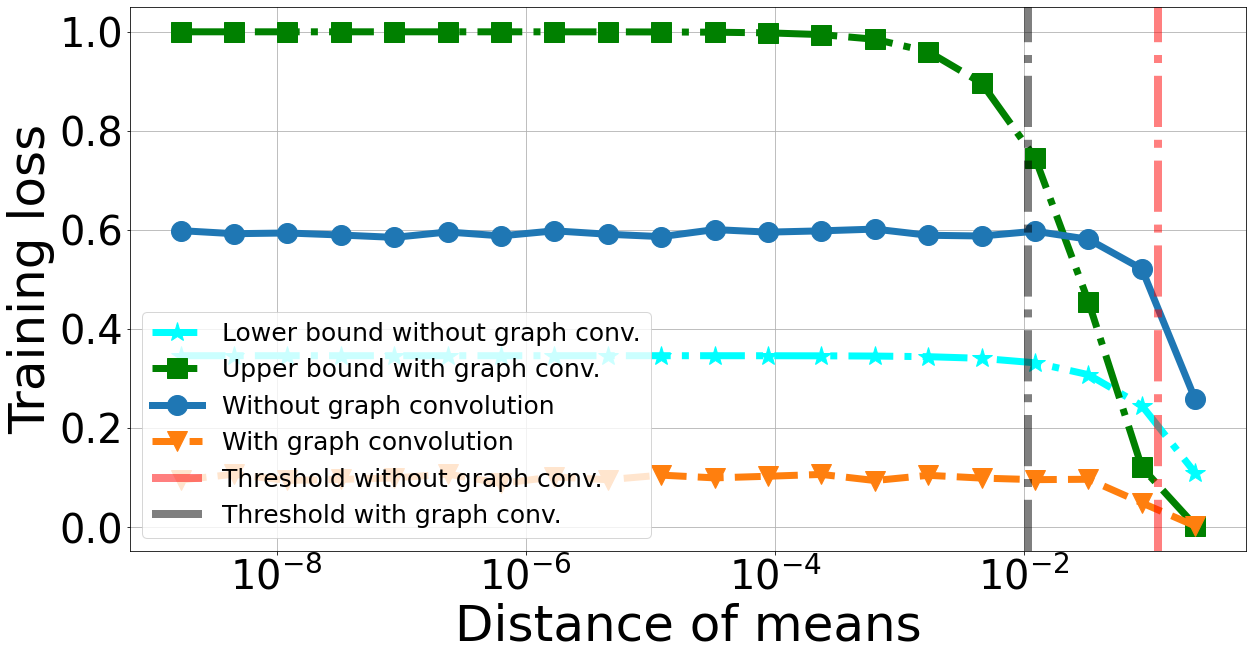

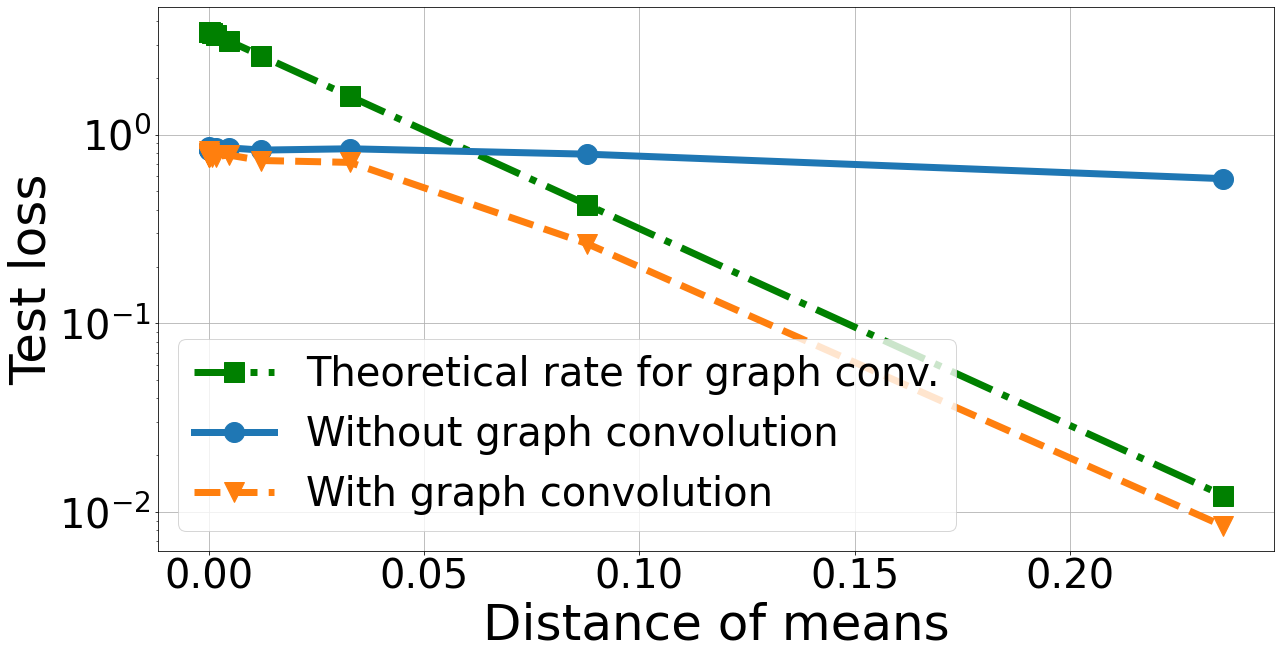

In [30]:
plot_lb = np.zeros(len(mus))
for idx, mu in enumerate(mus):
    val_ = 2*mu*n_features
    plot_lb[idx] = (1 - norm.cdf(0.5*val_))*np.log(2)
    
plot_ub = np.zeros(len(mus))
for idx, mu in enumerate(mus):
    plot_ub[idx] = np.exp(-0.5*n_features*(2*mu*np.sqrt(n_features))*(p-q)/(p+q))

plot_rate_test = np.zeros(len(mus))
for idx, mu in enumerate(mus):
    plot_rate_test[idx] = 3.5*np.exp(-0.5*n_features*(2*mu*np.sqrt(n_features))*(p-q)/(p+q))

fig = plt.figure(figsize=(20,10), facecolor=[1,1,1])
ax = plt.axes()
distances = []
for mu in mus:
    distances.append(2*mu*np.sqrt(n_features))

ax.plot(distances, plot_lb, linewidth=7, linestyle= '-.', marker='*', markersize=20, color='cyan', label='Lower bound without graph conv.')
ax.plot(distances, plot_ub, linewidth=7, linestyle= '-.', marker='s', markersize=20, color='green', label='Upper bound with graph conv.')
ax.plot(distances, plots_log, linewidth=7, linestyle= '-', marker='o', markersize=20, label='Without graph convolution')
ax.plot(distances, plots, linewidth=7, linestyle='--', marker='v', markersize=20, label='With graph convolution')
ax.axvline(x=1/np.sqrt(n_features), color='red', linewidth=8, linestyle='-.', alpha=0.5, label='Threshold without graph conv.')
ax.axvline(x=1/np.sqrt(n*n_features*(p+q)), color='black', linewidth=8, linestyle='-.', alpha=0.5, label='Threshold with graph conv.')

ax.set_xlabel('Distance of means', fontsize=50)
ax.set_ylabel('Training loss', fontsize=50)
ax.legend(loc='lower left', fontsize=25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xscale('log')
ax.grid()

fig.savefig('loss_vs_mean_train_result_trained_on_n='+str(2*n) + '_p='+str(p) + '_q='+str(q)+'.pdf', bbox_inches='tight')

fig = plt.figure(figsize=(20,10), facecolor=[1,1,1])
ax = plt.axes()
distances = []
for mu in mus:
    distances.append(2*mu*np.sqrt(n_features))
    
ax.plot(distances, plot_rate_test, linewidth=7, linestyle= '-.', marker='s', markersize=20, color='green', label='Theoretical rate for graph conv.')
ax.plot(distances, plots_log_test, linewidth=7, linestyle= '-', marker='o', markersize=20, label='Without graph convolution')
ax.plot(distances, plots_test, linewidth=7, linestyle='--', marker='v', markersize=20, label='With graph convolution')

ax.set_xlabel('Distance of means', fontsize=50)
ax.set_ylabel('Test loss', fontsize=50)
ax.legend(loc='lower left', fontsize=40)
plt.xticks(fontsize=40)w
plt.yticks(fontsize=40)
plt.yscale('log')
ax.grid()
# plt.title('Trained on n='+str(2*n) + ' p='+str(p) + ' q='+str(q), fontsize=25)

fig.savefig('loss_vs_mean_test_result_trained_on_n='+str(2*n) + '_p='+str(p) + '_q='+str(q)+'.pdf', bbox_inches='tight')
#         plt.show()